In [98]:
import numpy as np

In [99]:
import pandas as pd

In [100]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [101]:
email_data = pd.read_csv("spam.csv",encoding="latin1")

In [102]:
email_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [103]:
email_data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [104]:
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
email_data = email_data.drop(email_data[to_drop], axis=1)
# Renaming the columns because I feel fancy today
email_data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
email_data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


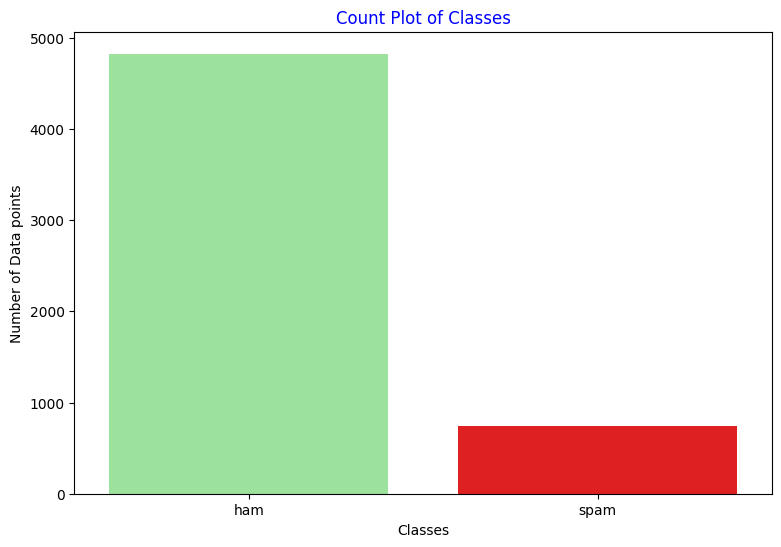

In [105]:
plt.figure(figsize=(9,6))
cols= ["#90EE90", "#FF0000"]
fg = sns.countplot(x= email_data["Target"], palette= cols)
fg.set_title("Count Plot of Classes", color="b")
fg.set_xlabel("Classes", color="k")
fg.set_ylabel("Number of Data points", color="k")
plt.show()

In [106]:
data= email_data

In [107]:
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe()

,No_of_Characters,No_of_Words,No_of_sentence
count,5572.000000,5572.000000,5572.000000
mean,80.118808,18.699390,1.996411
std,59.690841,13.741932,1.520159
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.500000
75%,121.000000,27.000000,2.000000
max,910.000000,220.000000,38.000000


<Figure size 1000x600 with 0 Axes>

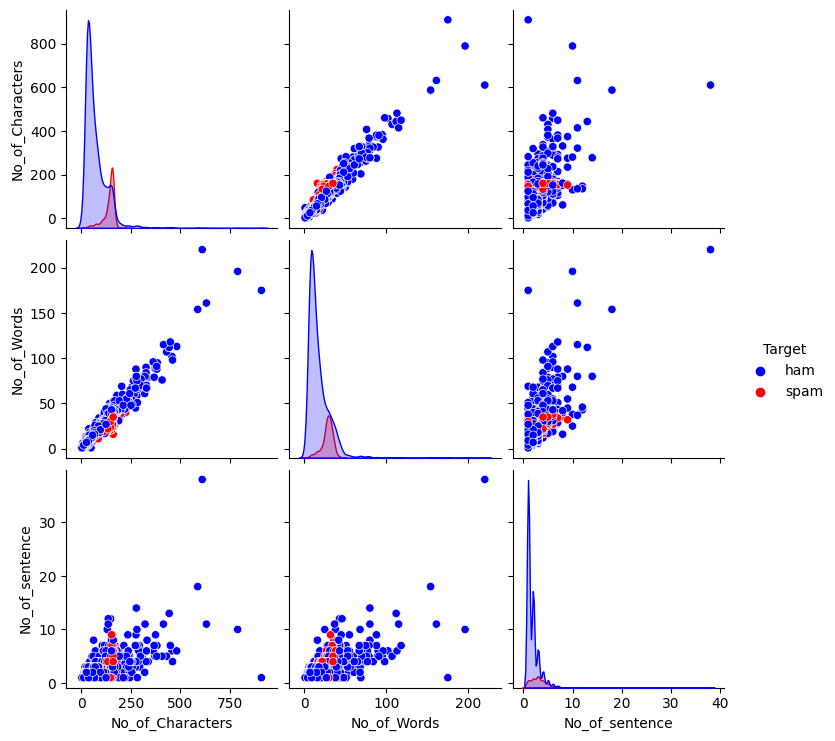

In [108]:
cols=["#0000FF","#FF0000"]
plt.figure(figsize=(10,6))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)
plt.show()

In [109]:
data = data[(data["No_of_Characters"]<350)]

<Figure size 800x500 with 0 Axes>

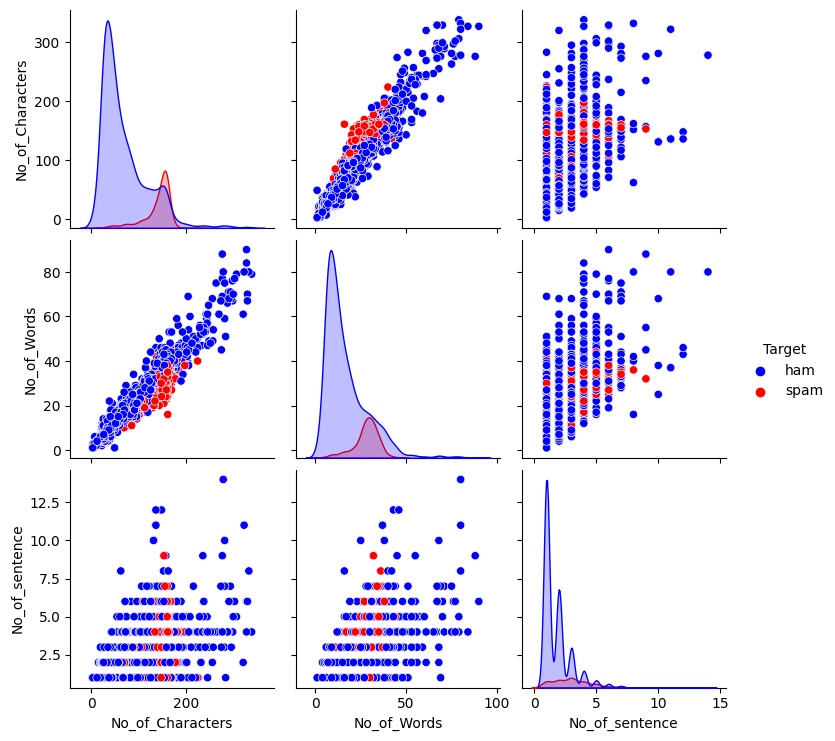

In [110]:
plt.figure(figsize=(8,5))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

Data Preprocessing

In [111]:
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text)

In [112]:
def Clean(sms):
    sms = sms.lower()
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)

print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m", *data["Clean_Text"][:5], sep="\n")

 The First 5 Texts after cleaning:
go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...
ok lar... joking wif u oni...
free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's
u dun say so early hor... u c already then say...
nah i don't think he goes to usf, he lives around here though


<ipython-input-112-89c3ca8090b4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Clean_Text"] = data["Text"].apply(Clean)


In [113]:
#tokenization
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', ',', 'crazy', '..', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'cine', 'there', 'got', 'amore', 'wat', '...']
['ok', 'lar', '...', 'joking', 'wif', 'u', 'oni', '...']
['free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005.', 'text', 'fa', 'to', '87121', 'to', 'receive', 'entry', 'question', '(', 'std', 'txt', 'rate', ')', 't', '&', 'c', "'s", 'apply', '08452810075over18', "'s"]
['u', 'dun', 'say', 'so', 'early', 'hor', '...', 'u', 'c', 'already', 'then', 'say', '...']
['nah', 'i', 'do', "n't", 'think', 'he', 'goes', 'to', 'usf', ',', 'he', 'lives', 'around', 'here', 'though']


<ipython-input-113-63c75091f70e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)


In [114]:
#stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', ',', 'crazy', '..', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'cine', 'got', 'amore', 'wat', '...']
['ok', 'lar', '...', 'joking', 'wif', 'u', 'oni', '...']
['free', 'entry', '2', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005.', 'text', 'fa', '87121', 'receive', 'entry', 'question', '(', 'std', 'txt', 'rate', ')', '&', 'c', "'s", 'apply', '08452810075over18', "'s"]
['u', 'dun', 'say', 'early', 'hor', '...', 'u', 'c', 'already', 'say', '...']
['nah', "n't", 'think', 'goes', 'usf', ',', 'lives', 'around', 'though']


<ipython-input-114-9952c5a116ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)


In [115]:
#lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_word(text):
  lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
  return lemmas
data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', ',', 'crazy', '..', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'cine', 'get', 'amore', 'wat', '...']
['ok', 'lar', '...', 'joke', 'wif', 'u', 'oni', '...']
['free', 'entry', '2', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005.', 'text', 'fa', '87121', 'receive', 'entry', 'question', '(', 'std', 'txt', 'rate', ')', '&', 'c', "'s", 'apply', '08452810075over18', "'s"]
['u', 'dun', 'say', 'early', 'hor', '...', 'u', 'c', 'already', 'say', '...']
['nah', "n't", 'think', 'go', 'usf', ',', 'live', 'around', 'though']


<ipython-input-115-c7a91e8d9bbe>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)


In [116]:
#vectorization
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point , crazy .. available bugis n great world la e buffet ... cine get amore wat ...
ok lar ... joke wif u oni ...
free entry 2 wkly comp win fa cup final tkts 21st may 2005. text fa 87121 receive entry question ( std txt rate ) & c 's apply 08452810075over18 's
u dun say early hor ... u c already say ...
nah n't think go usf , live around though


In [117]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

In [118]:
#using label encoder
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

<ipython-input-118-a7fd0bdde766>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Target"] = label_encoder.fit_transform(data["Target"])


MODEL TRAINING

In [119]:
y = data["Target"]
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Testing the classifier
classifiers = [MultinomialNB(),
               RandomForestClassifier(),
               KNeighborsClassifier(),
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.964397 
RandomForest: 0.974988 
KNeighbours: 0.898605 
SVC: 0.972510 


MODEL EVALUATION

In [120]:
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []
for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [121]:
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [122]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.742647,0.852321,0.978378,0.997972
RandomForest,1.000000,0.845588,0.916335,0.978378,0.997972
KNeighbours,1.000000,0.250000,0.400000,0.978378,0.997972
SVC,1.000000,0.823529,0.903226,0.978378,0.997972
